In [6]:
import numpy as np
import random
import time
import pandas

from keras.callbacks import LambdaCallback

from keras import optimizers
from keras.layers import Activation, Input, LSTM, Dense, Dropout, BatchNormalization, GRU, Flatten, TimeDistributed
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import concatenate

from pandas import read_csv
from socketIO_client import SocketIO, LoggingNamespace
from Audio.Components.MidiPlayer import MidiPlayer

from sklearn.preprocessing import MinMaxScaler

from keras.utils.vis_utils import model_to_dot
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

In [7]:
# socket = SocketIO('localhost', 9876, LoggingNamespace)
# from MidiPlayer import MidiPlayer
player = MidiPlayer()

['IAC Driver Bus 1', 'IAC Driver LocalMidi']


In [8]:
dropout = 0.02
n_time_steps = 12
semi_redundancy_step = 3

In [9]:
corpus = read_csv('Audio/data/output.csv', header=1)
print(list(corpus))
print('corpus length:', len(corpus))

['0', ' 0.28', ' 81']
corpus length: 204


In [10]:
notes_index = corpus.values[:, 0]
length_index = corpus.values[:, 1]
print(note_index)
print(length_index)

NameError: name 'note_index' is not defined

In [11]:
lengths = []
first_field = np.arange(0.0, 1., 0.01)
for value in list(first_field):
    lengths.append(round(value, 2))
    
second_field = np.arange(1.0, 5.1, 0.1)
for value in list(second_field):
    lengths.append(round(value, 1))
    
print(lengths)

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0]


In [12]:
# notes = sorted(list(set(notes_index)))
# lengths = sorted(list(set(length_index)))
notes = []
for i in range(0, 128):
    notes.append(i)


    
print('num_events:', len(notes))
# print(notes)
note_index = dict((c, i) for i, c in enumerate(notes))
index_note = dict((i, c) for i, c in enumerate(notes))

lengths_index = dict((c, i) for i, c in enumerate(lengths))
index_lengths = dict((i, c) for i, c in enumerate(lengths))
print(lengths_index)
print(index_lengths)

num_events: 128
{0.0: 0, 0.01: 1, 0.02: 2, 0.03: 3, 0.04: 4, 0.05: 5, 0.06: 6, 0.07: 7, 0.08: 8, 0.09: 9, 0.1: 10, 0.11: 11, 0.12: 12, 0.13: 13, 0.14: 14, 0.15: 15, 0.16: 16, 0.17: 17, 0.18: 18, 0.19: 19, 0.2: 20, 0.21: 21, 0.22: 22, 0.23: 23, 0.24: 24, 0.25: 25, 0.26: 26, 0.27: 27, 0.28: 28, 0.29: 29, 0.3: 30, 0.31: 31, 0.32: 32, 0.33: 33, 0.34: 34, 0.35: 35, 0.36: 36, 0.37: 37, 0.38: 38, 0.39: 39, 0.4: 40, 0.41: 41, 0.42: 42, 0.43: 43, 0.44: 44, 0.45: 45, 0.46: 46, 0.47: 47, 0.48: 48, 0.49: 49, 0.5: 50, 0.51: 51, 0.52: 52, 0.53: 53, 0.54: 54, 0.55: 55, 0.56: 56, 0.57: 57, 0.58: 58, 0.59: 59, 0.6: 60, 0.61: 61, 0.62: 62, 0.63: 63, 0.64: 64, 0.65: 65, 0.66: 66, 0.67: 67, 0.68: 68, 0.69: 69, 0.7: 70, 0.71: 71, 0.72: 72, 0.73: 73, 0.74: 74, 0.75: 75, 0.76: 76, 0.77: 77, 0.78: 78, 0.79: 79, 0.8: 80, 0.81: 81, 0.82: 82, 0.83: 83, 0.84: 84, 0.85: 85, 0.86: 86, 0.87: 87, 0.88: 88, 0.89: 89, 0.9: 90, 0.91: 91, 0.92: 92, 0.93: 93, 0.94: 94, 0.95: 95, 0.96: 96, 0.97: 97, 0.98: 98, 0.99: 99, 1.0

In [13]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(length_index[:].reshape(-1,1))
# length_index = scaler.transform(length_index[:].reshape(-1,1))
# print(length_index[0:3])

In [14]:
length_phrases = []
next_length = []
note_phrases = []
next_note = []
for i in range(0, len(notes_index) - n_time_steps, semi_redundancy_step):
    note_phrases.append(notes_index[i: i + n_time_steps])
    length_phrases.append(length_index[i: i + n_time_steps])
    
    next_note.append(notes_index[i + n_time_steps])
    next_length.append(length_index[i + n_time_steps])
print('nb sequences:', len(note_phrases))
# for i in range(2):
#     print('______________')
#     print('note_x', note_phrases[i])
#     print('note_y', next_note[i])
#     print('length_x', length_phrases[i])
#     print('length_y', next_length[i])
print(length_phrases)
print(next_length)

nb sequences: 64
[array([1.2 , 1.4 , 1.4 , 1.  , 1.3 , 1.6 , 1.7 , 0.09, 1.3 , 0.98, 2.3 ,
       1.5 ]), array([1.  , 1.3 , 1.6 , 1.7 , 0.09, 1.3 , 0.98, 2.3 , 1.5 , 1.6 , 1.4 ,
       0.98]), array([1.7 , 0.09, 1.3 , 0.98, 2.3 , 1.5 , 1.6 , 1.4 , 0.98, 1.2 , 1.7 ,
       1.8 ]), array([0.98, 2.3 , 1.5 , 1.6 , 1.4 , 0.98, 1.2 , 1.7 , 1.8 , 1.9 , 0.7 ,
       2.  ]), array([1.6 , 1.4 , 0.98, 1.2 , 1.7 , 1.8 , 1.9 , 0.7 , 2.  , 1.1 , 0.65,
       0.6 ]), array([1.2 , 1.7 , 1.8 , 1.9 , 0.7 , 2.  , 1.1 , 0.65, 0.6 , 0.05, 0.05,
       1.2 ]), array([1.9 , 0.7 , 2.  , 1.1 , 0.65, 0.6 , 0.05, 0.05, 1.2 , 1.5 , 0.7 ,
       0.51]), array([1.1 , 0.65, 0.6 , 0.05, 0.05, 1.2 , 1.5 , 0.7 , 0.51, 0.33, 0.51,
       1.3 ]), array([0.05, 0.05, 1.2 , 1.5 , 0.7 , 0.51, 0.33, 0.51, 1.3 , 0.93, 0.88,
       1.3 ]), array([1.5 , 0.7 , 0.51, 0.33, 0.51, 1.3 , 0.93, 0.88, 1.3 , 0.74, 0.05,
       0.05]), array([0.33, 0.51, 1.3 , 0.93, 0.88, 1.3 , 0.74, 0.05, 0.05, 0.14, 0.19,
       0.88]), array([0.93, 0

In [15]:
print('Vectorization...')

note_x = np.zeros((len(note_phrases), n_time_steps, len(notes)), dtype=np.bool)
note_y = np.zeros((len(note_phrases), len(notes)), dtype=np.bool)

length_x = np.zeros((len(length_phrases), n_time_steps, len(lengths)), dtype=np.bool)
length_y = np.zeros((len(length_phrases), len(lengths)), dtype=np.bool)

for i, phrase in enumerate(note_phrases):
    for t, note in enumerate(phrase):
        print(i, t, note)
        note_x[i, t, note_index[note]] = 1
    note_y[i, note_index[next_note[i]]] = 1

for i, phrase in enumerate(length_phrases):
    for t, length in enumerate(phrase):
        print(i, t, length)
        length_x[i, t, lengths_index[length]] = 1
    length_y[i, lengths_index[next_length[i]]] = 1
    
# print('______________')
# print('length_x', length_x[0])
# print('length_y', length_y[0])
# print('note_x', note_x[0])
# print('note_y', note_y[0])

Vectorization...
0 0 58.0
0 1 62.0
0 2 65.0
0 3 63.0
0 4 0.0
0 5 67.0
0 6 63.0
0 7 64.0
0 8 65.0
0 9 62.0
0 10 0.0
0 11 58.0
1 0 63.0
1 1 0.0
1 2 67.0
1 3 63.0
1 4 64.0
1 5 65.0
1 6 62.0
1 7 0.0
1 8 58.0
1 9 62.0
1 10 63.0
1 11 60.0
2 0 63.0
2 1 64.0
2 2 65.0
2 3 62.0
2 4 0.0
2 5 58.0
2 6 62.0
2 7 63.0
2 8 60.0
2 9 0.0
2 10 57.0
2 11 53.0
3 0 62.0
3 1 0.0
3 2 58.0
3 3 62.0
3 4 63.0
3 5 60.0
3 6 0.0
3 7 57.0
3 8 53.0
3 9 60.0
3 10 53.0
3 11 0.0
4 0 62.0
4 1 63.0
4 2 60.0
4 3 0.0
4 4 57.0
4 5 53.0
4 6 60.0
4 7 53.0
4 8 0.0
4 9 62.0
4 10 0.0
4 11 55.0
5 0 0.0
5 1 57.0
5 2 53.0
5 3 60.0
5 4 53.0
5 5 0.0
5 6 62.0
5 7 0.0
5 8 55.0
5 9 64.0
5 10 63.0
5 11 64.0
6 0 60.0
6 1 53.0
6 2 0.0
6 3 62.0
6 4 0.0
6 5 55.0
6 6 64.0
6 7 63.0
6 8 64.0
6 9 0.0
6 10 65.0
6 11 67.0
7 0 62.0
7 1 0.0
7 2 55.0
7 3 64.0
7 4 63.0
7 5 64.0
7 6 0.0
7 7 65.0
7 8 67.0
7 9 69.0
7 10 67.0
7 11 65.0
8 0 64.0
8 1 63.0
8 2 64.0
8 3 0.0
8 4 65.0
8 5 67.0
8 6 69.0
8 7 67.0
8 8 65.0
8 9 63.0
8 10 62.0
8 11 0.0
9 0 0.0
9 1 65.

31 9 0.33
31 10 0.33
31 11 0.28
32 0 0.05
32 1 0.05
32 2 0.46
32 3 0.42
32 4 0.65
32 5 2.1
32 6 0.33
32 7 0.33
32 8 0.28
32 9 0.33
32 10 0.33
32 11 0.09
33 0 0.42
33 1 0.65
33 2 2.1
33 3 0.33
33 4 0.33
33 5 0.28
33 6 0.33
33 7 0.33
33 8 0.09
33 9 0.42
33 10 0.33
33 11 0.28
34 0 0.33
34 1 0.33
34 2 0.28
34 3 0.33
34 4 0.33
34 5 0.09
34 6 0.42
34 7 0.33
34 8 0.28
34 9 0.33
34 10 0.37
34 11 0.37
35 0 0.33
35 1 0.33
35 2 0.09
35 3 0.42
35 4 0.33
35 5 0.28
35 6 0.33
35 7 0.37
35 8 0.37
35 9 0.56
35 10 0.09
35 11 0.09
36 0 0.42
36 1 0.33
36 2 0.28
36 3 0.33
36 4 0.37
36 5 0.37
36 6 0.56
36 7 0.09
36 8 0.09
36 9 0.19
36 10 0.65
36 11 1.0
37 0 0.33
37 1 0.37
37 2 0.37
37 3 0.56
37 4 0.09
37 5 0.09
37 6 0.19
37 7 0.65
37 8 1.0
37 9 1.3
37 10 0.46
37 11 0.33
38 0 0.56
38 1 0.09
38 2 0.09
38 3 0.19
38 4 0.65
38 5 1.0
38 6 1.3
38 7 0.46
38 8 0.33
38 9 0.84
38 10 0.46
38 11 0.33
39 0 0.19
39 1 0.65
39 2 1.0
39 3 1.3
39 4 0.46
39 5 0.33
39 6 0.84
39 7 0.46
39 8 0.33
39 9 0.14
39 10 0.37
39 11 0.56
4

In [16]:
print(note_x.shape)
print(length_x.shape)
print(note_y.shape)
print(length_y.shape)

(64, 12, 128)
(64, 12, 141)
(64, 128)
(64, 141)


In [17]:
lstm_size = 64

note_input = Input(name='note_input', shape=(n_time_steps, len(notes)))
length_input = Input(name='length_input', shape=(n_time_steps, len(lengths)))

# input_merge = concatenate([note_input, length_input])

# nn = LSTM(lstm_size, return_sequences=True)(input_merge)
# # nn = Dropout(dropout)(nn)
# nn = LSTM(lstm_size, return_sequences=True)(nn)

note_branch = LSTM(lstm_size, return_sequences=True)(note_input)
note_share = LSTM(int(lstm_size/4), return_sequences=True)(note_branch)

length_branch = LSTM(lstm_size, return_sequences=True)(length_input)
length_share = LSTM(int(lstm_size/4), return_sequences=True)(length_branch)

length_merge = concatenate([length_branch, note_share])
note_merge = concatenate([note_branch, length_share])

length_lstm = LSTM(lstm_size, return_sequences=False)(length_merge)
note_lstm = LSTM(lstm_size, return_sequences=False)(note_merge)
                    
output_notes = Dense(len(notes), activation='softmax', name='note_output')(note_lstm)
length_output = Dense(len(lengths), activation='softmax', name='length_output')(length_lstm)

optimizer = optimizers.RMSprop(lr=0.001)
model = Model(inputs=[note_input, length_input], outputs=[output_notes, length_output])
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=optimizer)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 12, 128)      0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 12, 141)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 12, 64)       49408       note_input[0][0]                 
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 12, 64)       52736       length_input[0][0]               
__________________________________________________________________________________________________
lstm_4 (LS

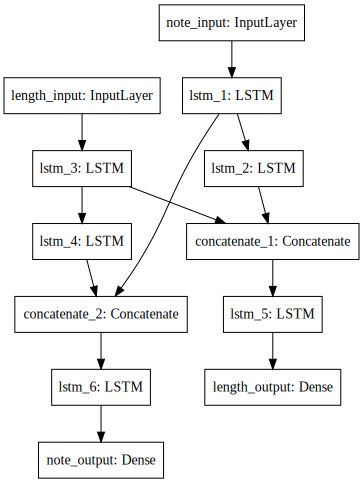

In [19]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [20]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [21]:
def midi_to_hertz(midi):
    if midi == 0:
        return 0
    g = 2**(1/12)
    return 440*g**(midi-69)

In [22]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    if epoch % 10 == 0 and epoch > 20:
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = 0
        for diversity in [1]:
            print('----- diversity:', diversity)

            generated_notes = []
            generated_length = []
            current_note_phrase = notes_index[start_index: start_index + n_time_steps]
            current_length_phrase = length_index[start_index: start_index + n_time_steps]
            generated_notes.extend(current_note_phrase)
            generated_length.extend(current_length_phrase)
    
            n_generated = 20
            start_time = time.time()
            for i in range(n_generated):
                x_pred = np.zeros((1, n_time_steps, len(notes)))
                length_x_pred = np.zeros((1, n_time_steps, len(lengths)))

                for t, event in enumerate(current_note_phrase):
                    x_pred[0, t, note_index[event]] = 1.

                for t, event in enumerate(current_length_phrase):
                    length_x_pred[0, t, lengths_index[event]] = 1

                pred = model.predict([x_pred, length_x_pred], verbose=0)
                note_pred = pred[0][0]
                length_pred = pred[1][0]
                
                note_index_from_sample = sample(note_pred, diversity)
                note_prediction = index_note[note_index_from_sample]
                
                length_index_from_sample = sample(length_pred, diversity)
                length_prediction = index_lengths[length_index_from_sample]
                
#                 print(note_prediction)
#                 print(length_prediction)
                
                generated_notes.append(note_prediction)
                generated_length.append(length_prediction)
                
                current_note_phrase = np.append(current_note_phrase[1:], note_prediction)
                current_length_phrase = np.append(current_length_phrase[1:], length_prediction)
                
                end_time = time.time()
            counter = 0
            for i in range(len(generated_notes)):
                note = generated_notes[i]
                length = generated_length[i]
#                 freq = midi_to_hertz(note)
                print(note, '|', length)
                player.play(note, length, 100)
#                     socket.emit('freq_change', {'freq': 4000, 'vol': 100})
                time.sleep(0.03)

                #socket.emit('freq_change', {'freq': freq, 'vol': 100})
                time.sleep(length * .5)


            #socket.emit('freq_change', {'freq': 0, 'vol': 100})

In [25]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit([note_x, length_x], [note_y, length_y],
          batch_size=256,
          epochs=100,
          callbacks=[print_callback]
        )

Epoch 1/100
64/64 [==============================] - 0s 1ms/step - loss: 5.5997 - note_output_loss: 2.5659 - length_output_loss: 3.0338
Epoch 2/100
64/64 [==============================] - 0s 1ms/step - loss: 5.5820 - note_output_loss: 2.5664 - length_output_loss: 3.0156
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 5.5694 - note_output_loss: 2.5592 - length_output_loss: 3.0102
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 5.5474 - note_output_loss: 2.5576 - length_output_loss: 2.9897
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 5.5572 - note_output_loss: 2.5690 - length_output_loss: 2.9882
Epoch 6/100
64/64 [==============================] - 0s 1ms/step - loss: 5.5301 - note_output_loss: 2.5617 - length_output_loss: 2.9684
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 5.5176 - note_output_loss: 2.5439 - length_output_loss: 2.9737
Epoch 8/100
64/64 [=============================

Epoch 53/100
64/64 [==============================] - 0s 2ms/step - loss: 4.5243 - note_output_loss: 2.0710 - length_output_loss: 2.4533
Epoch 54/100
64/64 [==============================] - 0s 1ms/step - loss: 4.5031 - note_output_loss: 2.0487 - length_output_loss: 2.4544
Epoch 55/100
64/64 [==============================] - 0s 1ms/step - loss: 4.4581 - note_output_loss: 2.0215 - length_output_loss: 2.4366
Epoch 56/100
64/64 [==============================] - 0s 2ms/step - loss: 4.4371 - note_output_loss: 2.0068 - length_output_loss: 2.4303
Epoch 57/100
64/64 [==============================] - 0s 2ms/step - loss: 4.3800 - note_output_loss: 1.9848 - length_output_loss: 2.3951
Epoch 58/100
64/64 [==============================] - 0s 2ms/step - loss: 4.3307 - note_output_loss: 1.9623 - length_output_loss: 2.3684
Epoch 59/100
64/64 [==============================] - 0s 2ms/step - loss: 4.3300 - note_output_loss: 1.9603 - length_output_loss: 2.3697
Epoch 60/100
64/64 [=====================

KeyboardInterrupt: 

In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
